1. ~~First, try to replicate the Cifar10 dataset work.~~
2. If Step 1 works, try replicating with the demo HDD dataset. **We have to include the bounding boxes**
3. If Step 2 works, write the `train` and `test` functions.

Import necessary libraries

In [3]:
from tensorflow.keras import layers, models
# from tensorflow.keras.callbacks import LearningRateScheduler, EarlyStopping
from tensorflow.keras.optimizers import Adam
# from tensorflow.keras.preprocessing.image import ImageDataGenerator
# from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical
import cv2
import matplotlib.pyplot as plt
import numpy as np
import os
import tensorflow as tf

Utility functions provided from class

In [5]:
## Utility functions

def load_yolo_labels(label_file):
    """ Load YOLO labels from a file. """
    with open(label_file, 'r') as f:
        labels = f.readlines()
    return [list(map(float, label.strip().split())) for label in labels]

def convert_to_pixel_coordinates(yolo_bbox, image_width, image_height):
    """ Convert YOLO normalized bounding box to pixel coordinates. """
    x_center, y_center, w, h = yolo_bbox[0], yolo_bbox[1], yolo_bbox[2], yolo_bbox[3]
    
    # Convert to pixel values
    x_center *= image_width
    y_center *= image_height
    w *= image_width
    h *= image_height
    
    # Calculate the top-left and bottom-right corners
    x1 = x_center - w / 2
    y1 = y_center - h / 2
    x2 = x_center + w / 2
    y2 = y_center + h / 2
    
    return x1, y1, x2, y2

def plot_bounding_boxes(image_path, label_file):
    """ Plot bounding boxes from YOLO label file on an image. """
    # Load image
    image = cv2.imread(image_path)
    image_height, image_width, _ = image.shape
    
    # Load YOLO labels
    labels = load_yolo_labels(label_file)
    
    # Plot bounding boxes
    plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
    ax = plt.gca()
    
    for label in labels:
        class_id, *bbox = label
        x1, y1, x2, y2 = convert_to_pixel_coordinates(bbox, image_width, image_height)
        
        # Draw the bounding box on the image
        ax.add_patch(plt.Rectangle((x1, y1), x2 - x1, y2 - y1, 
                                   linewidth=2, edgecolor='red', facecolor='none'))
        ax.text(x1, y1, f'Class {int(class_id)}', color='white', fontsize=12, 
                bbox=dict(facecolor='red', alpha=0.5))
    
    # Display the image
    plt.axis('off')
    # plt.show()

Function to parse YOLO annotations

In [7]:
# This is no longer needed

# def parse_yolo_annotations(coord_dir, img_dir, img_size=(640, 640)):
#     images = []
#     labels = []
    
#     for label_file in os.listdir(coord_dir):
#         if label_file.endswith(".txt"):
#             # Image path
#             img_name = label_file.replace(".txt", ".jpg")
#             img_path = os.path.join(img_dir, img_name)
            
#             if not os.path.exists(img_path):
#                 continue  # Skip if corresponding image is missing
            
#             # Load image and resize
#             img = cv2.imread(img_path)
#             img = cv2.resize(img, img_size) / 255.0  # Normalize pixel values
#             images.append(img)
            
#             # Load YOLO labels
#             yolo_labels = load_yolo_labels(os.path.join(coord_dir, label_file))
#             class_ids = [int(label[0]) for label in yolo_labels]  # Extract class IDs
#             labels.append(class_ids)
    
#     return np.array(images), np.array(labels, dtype=object)

New functions to find ROI from bounded boxes

In [9]:
def parse_yolo_labels(label_file, image_width, image_height):
    bboxes = []
    
    # Load YOLO labels
    yolo_labels = load_yolo_labels(label_file)
    
    for label in yolo_labels:
        class_id, *bbox = label
        x1, y1, x2, y2 = convert_to_pixel_coordinates(bbox, image_width, image_height)
        bboxes.append((int(class_id), int(x1), int(y1), int(x2), int(y2)))
    
    return bboxes


def process_images_and_labels(image_dir, label_dir, output_size=(28, 28)):
    images = []
    labels = []
    
    for label_file in os.listdir(label_dir):
        if label_file.endswith(".txt"):
            # Image path
            img_name = label_file.replace(".txt", ".jpg")
            img_path = os.path.join(image_dir, img_name)
            
            if not os.path.exists(img_path):
                print(f"Warning: Image file {img_path} missing. Skipping.")
                continue
            
            # Load image
            img = cv2.imread(img_path)
            if img is None:
                print(f"Warning: Could not load image {img_path}. Skipping.")
                continue
            img_height, img_width, _ = img.shape
            
            # Parse YOLO labels and extract bounding boxes
            label_path = os.path.join(label_dir, label_file)
            bboxes = parse_yolo_labels(label_path, img_width, img_height)
            
            for class_id, x_min, y_min, x_max, y_max in bboxes:
                # Extract and resize ROI
                roi = img[y_min:y_max, x_min:x_max]
                if roi.size == 0:  # Skip if the bounding box is invalid
                    print(f"Warning: Invalid bounding box in {label_file}. Skipping.")
                    continue
                roi_resized = cv2.resize(roi, output_size) / 255.0  # Normalize
                
                images.append(roi_resized)
                labels.append(class_id)
    
    # Convert to numpy arrays
    images = np.array(images, dtype=np.float32)
    labels = np.array(labels, dtype=np.int32)
    
    return images, labels


Load Dataset

In [11]:
# Define directories
train_img_dir = "Training Set/Training Images/"
train_coords_dir = "Training Set/Training Coordinates/"
test_img_dir = "Testing Set/Testing Images/"
test_coords_dir = "Testing Set/Testing Coordinates/"

# Define target size for ROIs (e.g., 28x28)
output_size = (28, 28)

# Load and process training data
train_images, train_labels = process_images_and_labels(train_img_dir, train_coords_dir, output_size)

# Load and process testing data
test_images, test_labels = process_images_and_labels(test_img_dir, test_coords_dir, output_size)

# Print summary of processed data
print(f"Training set: {len(train_images)} ROIs with labels")
print(f"Testing set: {len(test_images)} ROIs with labels")

# Example shape
print(f"Example ROI shape: {train_images[0].shape}")
print(f"Example label: {train_labels[0]}")


Training set: 172 ROIs with labels
Testing set: 27 ROIs with labels
Example ROI shape: (28, 28, 3)
Example label: 7


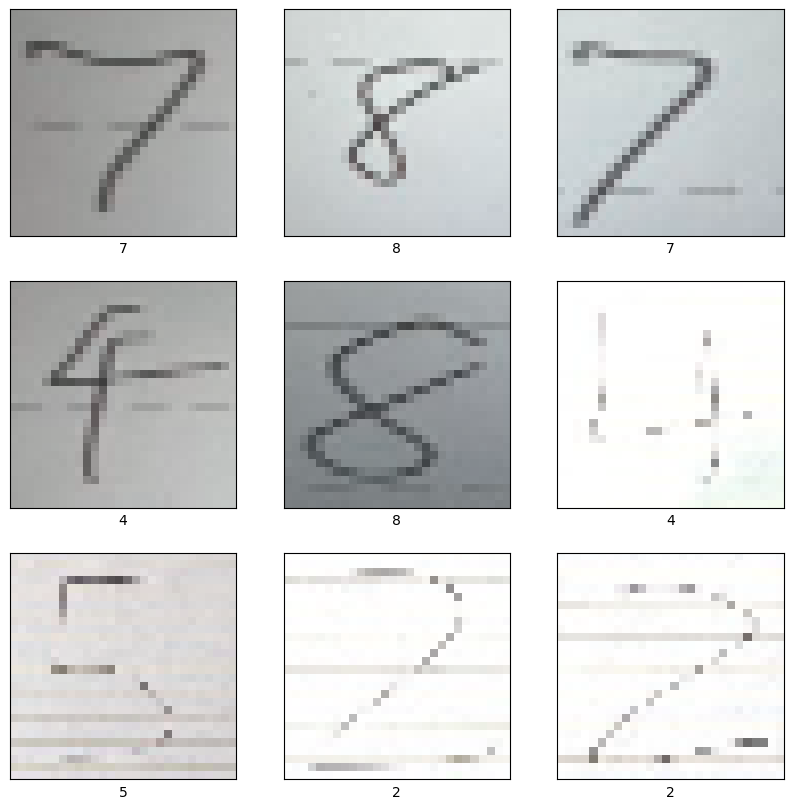

In [40]:
plt.figure(figsize=(10,10))
for i in range(9):
    plt.subplot(3,3,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(train_images[2*i])
    plt.xlabel(train_labels[2*i])
plt.show()

Create the convolutional base

In [16]:
# Define the CNN architecture
model = models.Sequential()

# Convolutional layers
model.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=(28, 28, 3)))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(64, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(128, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))

# Flatten and dense layers
model.add(layers.Flatten())
model.add(layers.Dense(128, activation='relu'))
model.add(layers.Dropout(0.5))  # Dropout to prevent overfitting
model.add(layers.Dense(10, activation='softmax'))  # Output layer for 10 digits

C:\Users\AsusG14\anaconda3\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [17]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 26, 26, 32)          │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 13, 13, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 11, 11, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 5, 5, 64)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 3, 3, 128)           │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 1, 1, 128)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 128)                 │          16,512 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 10)                  │           1,290 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 111,050 (433.79 KB)

 Trainable params: 111,050 (433.79 KB)

 Non-trainable params: 0 (0.00 B)

Augmentation, Learning Rate Scheduler and Early Stopping
Will use them only if asked to

In [19]:
# # Data Augmentation
# datagen = ImageDataGenerator(
#     rotation_range=15,
#     width_shift_range=0.1,
#     height_shift_range=0.1,
#     zoom_range=0.1
# )

# # Fit the generator to your training data
# datagen.fit(train_images)

# # Learning Rate Scheduler
# def lr_schedule(epoch, lr):
#     if epoch > 5:
#         return lr * 0.1  # Decrease learning rate after 5 epochs
#     return lr

# lr_callback = LearningRateScheduler(lr_schedule)

# # Early Stopping
# early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

Compile and train the model

In [21]:
# # Compile the model
# model.compile(optimizer=Adam(learning_rate=0.001),
#               loss='sparse_categorical_crossentropy',  # Use sparse categorical since labels are integers
#               metrics=['accuracy'])

# # Train the model
# history = model.fit(
#     train_images, train_labels,
#     epochs=10,  # Adjust epochs based on performance
#     batch_size=32,  # Adjust batch size based on dataset size and available hardware
#     validation_data=(test_images, test_labels)
# )

# # # Compile the model
# # model.compile(optimizer=Adam(learning_rate=0.001),
# #               loss='sparse_categorical_crossentropy',  # Use sparse categorical since labels are integers
# #               metrics=['accuracy'])

# # # Train the model
# # history = model.fit(
# #     datagen.flow(train_images, train_labels, batch_size=32),
# #     epochs=10,
# #     validation_data=(test_images, test_labels)
# # )

# # # # Use the generator for training
# # # history = model.fit(
# # #     datagen.flow(train_images, train_labels, batch_size=32),
# # #     epochs=10,
# # #     validation_data=(test_images, test_labels),
# # #     callbacks=[lr_callback, early_stopping]
# # # )

Epoch 1/10
6/6 ━━━━━━━━━━━━━━━━━━━━ 2s 41ms/step - accuracy: 0.1290 - loss: 2.3241 - val_accuracy: 0.0000e+00 - val_loss: 2.3486
Epoch 2/10
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.0718 - loss: 2.3194 - val_accuracy: 0.0000e+00 - val_loss: 2.3107
Epoch 3/10
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.0780 - loss: 2.3016 - val_accuracy: 0.1111 - val_loss: 2.3208
Epoch 4/10
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.1511 - loss: 2.2888 - val_accuracy: 0.1111 - val_loss: 2.3294
Epoch 5/10
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.0959 - loss: 2.2978 - val_accuracy: 0.1111 - val_loss: 2.3240
Epoch 6/10
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.1372 - loss: 2.2935 - val_accuracy: 0.1111 - val_loss: 2.3278
Epoch 7/10
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.1470 - loss: 2.2904 - val_accuracy: 0.1481 - val_loss: 2.3184
Epoch 8/10
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.1577 - loss: 2.2848 - val_accuracy: 0.1111 - val_loss: 2.3198

Evaluate the model

1/1 - 0s - 16ms/step - accuracy: 0.1111 - loss: 2.3324
Test accuracy: 0.1111111119389534


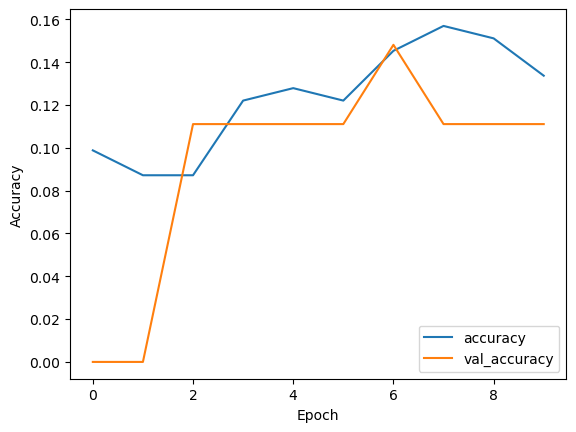

In [23]:
# test_loss, test_acc = model.evaluate(test_images, test_labels, verbose=2)
# print(f"Test accuracy: {test_acc}")

# # Plot training history
# plt.plot(history.history['accuracy'], label='accuracy')
# plt.plot(history.history['val_accuracy'], label='val_accuracy')
# plt.xlabel('Epoch')
# plt.ylabel('Accuracy')
# plt.legend(loc='lower right')
# plt.show()

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step


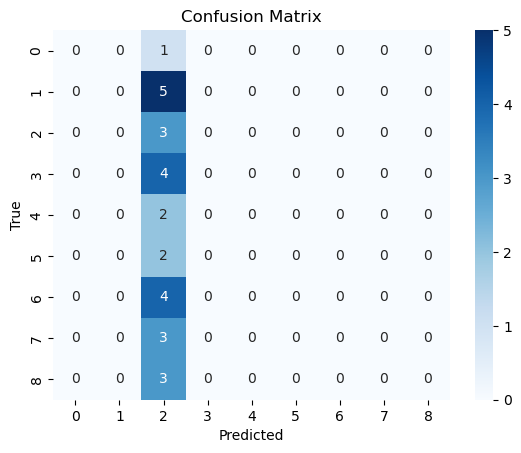

              precision    recall  f1-score   support

           0       0.00      0.00      0.00         1
           1       0.00      0.00      0.00         5
           2       0.11      1.00      0.20         3
           3       0.00      0.00      0.00         4
           4       0.00      0.00      0.00         2
           5       0.00      0.00      0.00         2
           7       0.00      0.00      0.00         4
           8       0.00      0.00      0.00         3
           9       0.00      0.00      0.00         3

    accuracy                           0.11        27
   macro avg       0.01      0.11      0.02        27
weighted avg       0.01      0.11      0.02        27



C:\Users\AsusG14\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\AsusG14\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\AsusG14\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [24]:
# from sklearn.metrics import confusion_matrix, classification_report
# import seaborn as sns

# # Predict test labels
# predictions = model.predict(test_images)
# predicted_labels = np.argmax(predictions, axis=1)

# # Confusion Matrix
# cm = confusion_matrix(test_labels, predicted_labels)
# sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
# plt.xlabel('Predicted')
# plt.ylabel('True')
# plt.title('Confusion Matrix')
# plt.show()

# # Classification Report
# print(classification_report(test_labels, predicted_labels))


Epoch 1/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - accuracy: 1.0000 - loss: 7.3521e-05 - val_accuracy: 0.6667 - val_loss: 2.8762
Epoch 2/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 1.0000 - loss: 0.0021 - val_accuracy: 0.7407 - val_loss: 2.4732
Epoch 3/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 1.0000 - loss: 4.5996e-04 - val_accuracy: 0.7037 - val_loss: 2.9692
Epoch 4/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 1.0000 - loss: 0.0023 - val_accuracy: 0.7407 - val_loss: 3.0725
Epoch 5/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 1.0000 - loss: 0.0031 - val_accuracy: 0.6296 - val_loss: 3.4020
Epoch 6/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 1.0000 - loss: 0.0015 - val_accuracy: 0.6667 - val_loss: 3.4906
Epoch 7/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9981 - loss: 0.0037 - val_accuracy: 0.6296 - val_loss: 3.4330
Epoch 8/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9995 - loss: 0.0017 - val_accuracy: 0.6667 - 

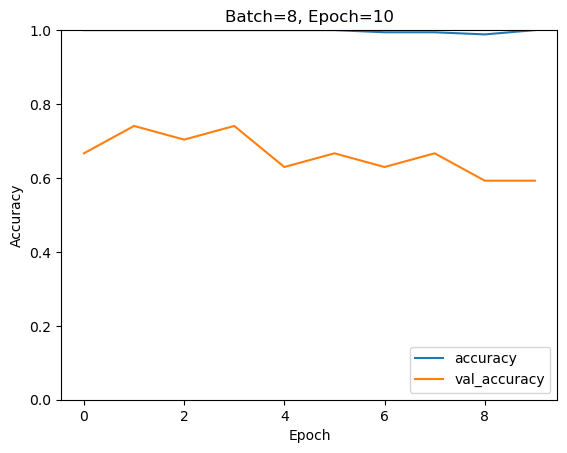

Epoch 1/10
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 1.0000 - loss: 4.4925e-04 - val_accuracy: 0.6296 - val_loss: 3.9136
Epoch 2/10
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 1.0000 - loss: 2.4062e-05 - val_accuracy: 0.6296 - val_loss: 3.8295
Epoch 3/10
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 1.0000 - loss: 8.5124e-04 - val_accuracy: 0.6296 - val_loss: 3.7710
Epoch 4/10
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 1.0000 - loss: 5.2175e-04 - val_accuracy: 0.7037 - val_loss: 3.6736
Epoch 5/10
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 1.0000 - loss: 0.0035 - val_accuracy: 0.6667 - val_loss: 3.8266
Epoch 6/10
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 1.0000 - loss: 0.0012 - val_accuracy: 0.6667 - val_loss: 3.9241
Epoch 7/10
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 1.0000 - loss: 0.0035 - val_accuracy: 0.6667 - val_loss: 3.6418
Epoch 8/10
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 1.0000 - loss: 0.0016 - val_accuracy: 0.

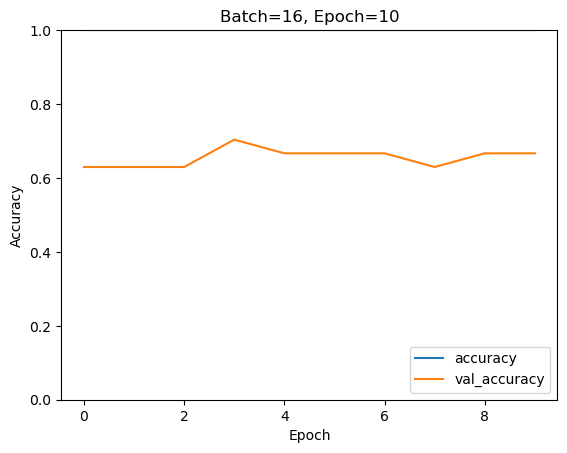

Epoch 1/10
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 1.0000 - loss: 2.9534e-04 - val_accuracy: 0.6667 - val_loss: 3.9375
Epoch 2/10
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 1.6361e-04 - val_accuracy: 0.6667 - val_loss: 3.9422
Epoch 3/10
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 8.2767e-05 - val_accuracy: 0.6667 - val_loss: 3.9456
Epoch 4/10
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 1.0000 - loss: 2.2294e-04 - val_accuracy: 0.6667 - val_loss: 3.9464
Epoch 5/10
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 1.1573e-04 - val_accuracy: 0.7037 - val_loss: 3.9566
Epoch 6/10
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 1.0000 - loss: 3.4604e-04 - val_accuracy: 0.7037 - val_loss: 3.9536
Epoch 7/10
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 0.0011 - val_accuracy: 0.6667 - val_loss: 3.8746
Epoch 8/10
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 1.5621e-04 - val_accuracy: 0.666

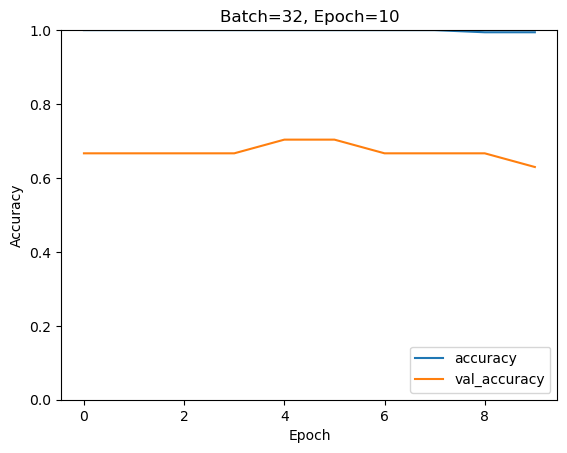

Epoch 1/10
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - accuracy: 1.0000 - loss: 0.0015 - val_accuracy: 0.6296 - val_loss: 3.9593
Epoch 2/10
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 1.0000 - loss: 5.3900e-05 - val_accuracy: 0.6296 - val_loss: 3.8708
Epoch 3/10
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 1.0000 - loss: 2.3753e-04 - val_accuracy: 0.6667 - val_loss: 3.8139
Epoch 4/10
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 1.0000 - loss: 0.0012 - val_accuracy: 0.6296 - val_loss: 3.7822
Epoch 5/10
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 1.0000 - loss: 4.7806e-05 - val_accuracy: 0.6296 - val_loss: 3.7713
Epoch 6/10
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 1.0000 - loss: 4.7893e-05 - val_accuracy: 0.6296 - val_loss: 3.7701
Epoch 7/10
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - accuracy: 1.0000 - loss: 5.0892e-04 - val_accuracy: 0.6296 - val_loss: 3.7625
Epoch 8/10
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 1.0000 - loss: 6.2663e-04 - val_accuracy: 0.

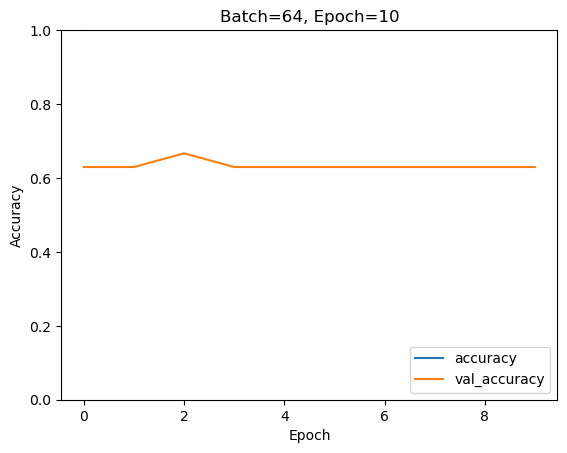

Epoch 1/20
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 1.0000 - loss: 0.0011 - val_accuracy: 0.6667 - val_loss: 3.7053
Epoch 2/20
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 1.0000 - loss: 2.6347e-05 - val_accuracy: 0.6296 - val_loss: 3.7574
Epoch 3/20
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 1.0000 - loss: 2.6221e-04 - val_accuracy: 0.6296 - val_loss: 3.9050
Epoch 4/20
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 1.0000 - loss: 9.3309e-06 - val_accuracy: 0.6667 - val_loss: 3.9607
Epoch 5/20
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 1.0000 - loss: 5.7068e-05 - val_accuracy: 0.6667 - val_loss: 3.9680
Epoch 6/20
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 1.0000 - loss: 6.2672e-05 - val_accuracy: 0.6667 - val_loss: 3.9531
Epoch 7/20
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 1.0000 - loss: 3.0278e-04 - val_accuracy: 0.6296 - val_loss: 4.0727
Epoch 8/20
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 1.0000 - loss: 7.6644e-05 - val_

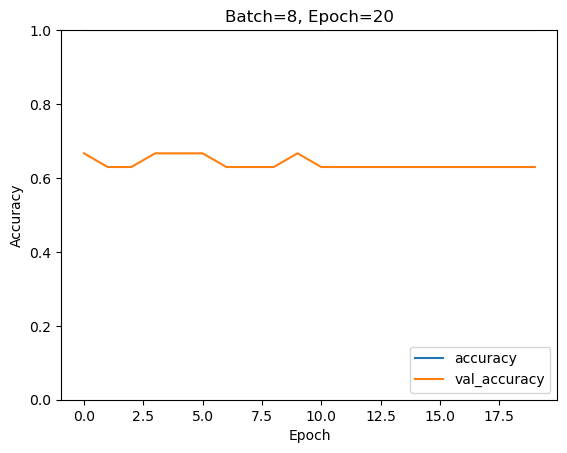

Epoch 1/20
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 1.0000 - loss: 0.0020 - val_accuracy: 0.6296 - val_loss: 4.1617
Epoch 2/20
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 1.0000 - loss: 6.6602e-05 - val_accuracy: 0.6296 - val_loss: 4.1934
Epoch 3/20
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 1.0000 - loss: 4.1227e-06 - val_accuracy: 0.6296 - val_loss: 4.1934
Epoch 4/20
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 1.0000 - loss: 5.0651e-05 - val_accuracy: 0.6296 - val_loss: 4.1758
Epoch 5/20
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 1.0000 - loss: 5.5895e-05 - val_accuracy: 0.6296 - val_loss: 4.0917
Epoch 6/20
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 1.0000 - loss: 1.9639e-05 - val_accuracy: 0.6667 - val_loss: 3.9149
Epoch 7/20
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 1.0000 - loss: 5.7737e-06 - val_accuracy: 0.7037 - val_loss: 3.7662
Epoch 8/20
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 1.0000 - loss: 2.4778e-04 - val

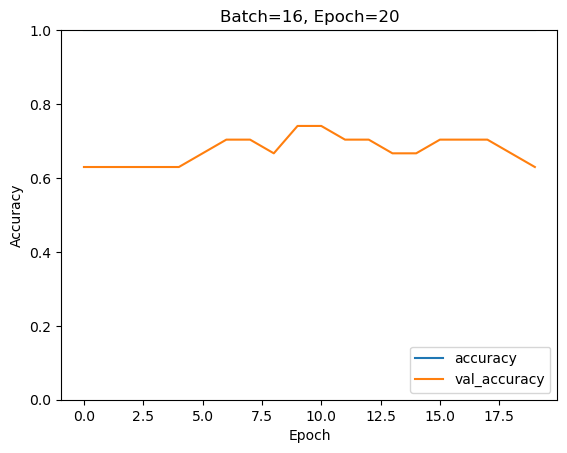

Epoch 1/20
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 1.0000 - loss: 1.5085e-06 - val_accuracy: 0.6296 - val_loss: 4.0344
Epoch 2/20
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 2.4951e-04 - val_accuracy: 0.6296 - val_loss: 3.9625
Epoch 3/20
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 1.0000 - loss: 3.7485e-06 - val_accuracy: 0.7037 - val_loss: 3.8026
Epoch 4/20
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 2.9063e-04 - val_accuracy: 0.7037 - val_loss: 3.7602
Epoch 5/20
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 1.3472e-05 - val_accuracy: 0.6667 - val_loss: 3.8009
Epoch 6/20
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 4.0176e-04 - val_accuracy: 0.6296 - val_loss: 3.8442
Epoch 7/20
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 1.4791e-04 - val_accuracy: 0.6296 - val_loss: 3.8698
Epoch 8/20
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 7.3828e-06 - val_accuracy: 0

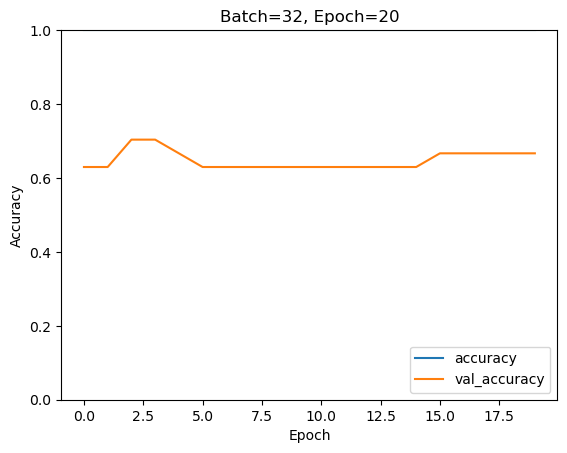

Epoch 1/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - accuracy: 1.0000 - loss: 3.4506e-05 - val_accuracy: 0.6667 - val_loss: 3.6173
Epoch 2/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 1.0000 - loss: 8.4984e-04 - val_accuracy: 0.6296 - val_loss: 3.6775
Epoch 3/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 1.0000 - loss: 2.7579e-04 - val_accuracy: 0.6296 - val_loss: 3.8088
Epoch 4/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 1.0000 - loss: 1.0486e-04 - val_accuracy: 0.6296 - val_loss: 3.9218
Epoch 5/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 1.0000 - loss: 1.4658e-05 - val_accuracy: 0.6296 - val_loss: 3.9959
Epoch 6/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 1.0000 - loss: 1.3869e-04 - val_accuracy: 0.6296 - val_loss: 4.0472
Epoch 7/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 1.0000 - loss: 2.8302e-06 - val_accuracy: 0.6296 - val_loss: 4.0814
Epoch 8/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 1.0000 - loss: 5.4405e-04 - val_accu

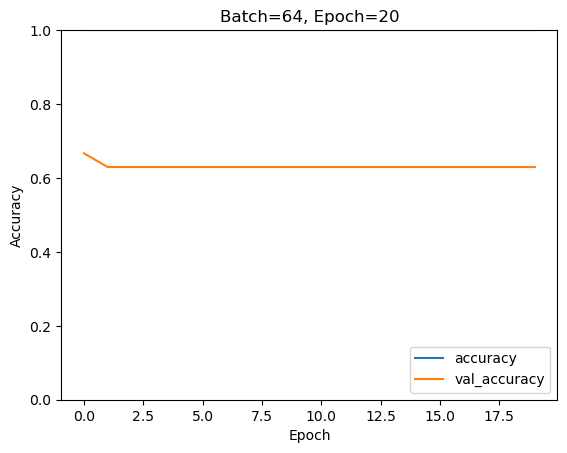

Epoch 1/30
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 1.0000 - loss: 1.9468e-06 - val_accuracy: 0.6296 - val_loss: 4.2044
Epoch 2/30
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 1.0000 - loss: 1.2235e-06 - val_accuracy: 0.6296 - val_loss: 4.2028
Epoch 3/30
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 1.0000 - loss: 2.5421e-06 - val_accuracy: 0.6296 - val_loss: 4.2050
Epoch 4/30
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 1.0000 - loss: 5.5782e-05 - val_accuracy: 0.6296 - val_loss: 4.3156
Epoch 5/30
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 1.0000 - loss: 4.5907e-06 - val_accuracy: 0.6296 - val_loss: 4.3256
Epoch 6/30
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 1.0000 - loss: 5.0942e-06 - val_accuracy: 0.6296 - val_loss: 4.3129
Epoch 7/30
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 1.0000 - loss: 1.1497e-05 - val_accuracy: 0.6296 - val_loss: 4.2812
Epoch 8/30
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 1.0000 - loss: 2.5616e-06 - 

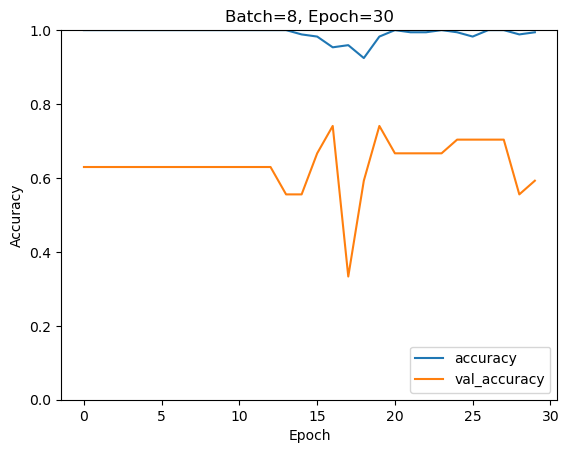

Epoch 1/30
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.9990 - loss: 0.0053 - val_accuracy: 0.5556 - val_loss: 4.0013
Epoch 2/30
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9838 - loss: 0.0292 - val_accuracy: 0.6296 - val_loss: 3.6916
Epoch 3/30
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9979 - loss: 0.0081 - val_accuracy: 0.6296 - val_loss: 3.7411
Epoch 4/30
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 1.0000 - loss: 3.4760e-04 - val_accuracy: 0.5556 - val_loss: 3.3769
Epoch 5/30
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 1.0000 - loss: 0.0018 - val_accuracy: 0.5556 - val_loss: 3.2683
Epoch 6/30
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 1.0000 - loss: 7.6203e-04 - val_accuracy: 0.5926 - val_loss: 3.2558
Epoch 7/30
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 1.0000 - loss: 6.7041e-04 - val_accuracy: 0.5926 - val_loss: 3.2621
Epoch 8/30
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 1.0000 - loss: 0.0013 - val_accuracy: 0.7037

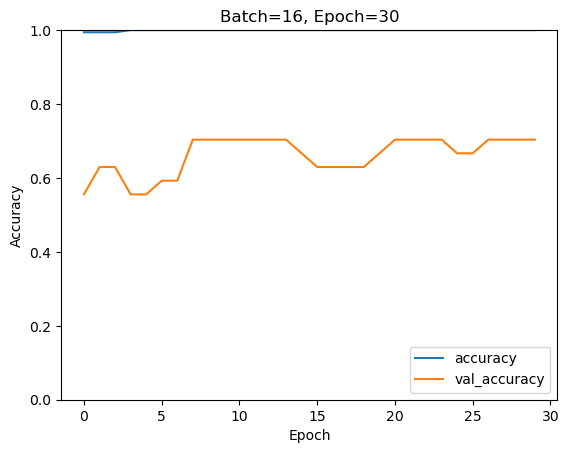

Epoch 1/30
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 1.0000 - loss: 6.0985e-05 - val_accuracy: 0.7037 - val_loss: 3.2963
Epoch 2/30
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 4.8346e-05 - val_accuracy: 0.7037 - val_loss: 3.2964
Epoch 3/30
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 1.6407e-05 - val_accuracy: 0.7037 - val_loss: 3.2965
Epoch 4/30
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 1.0000 - loss: 9.2819e-05 - val_accuracy: 0.7037 - val_loss: 3.2966
Epoch 5/30
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 1.2512e-04 - val_accuracy: 0.7037 - val_loss: 3.2963
Epoch 6/30
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 2.5310e-04 - val_accuracy: 0.7037 - val_loss: 3.2969
Epoch 7/30
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 4.1366e-05 - val_accuracy: 0.7037 - val_loss: 3.2979
Epoch 8/30
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 0.0013 - val_accuracy: 0.703

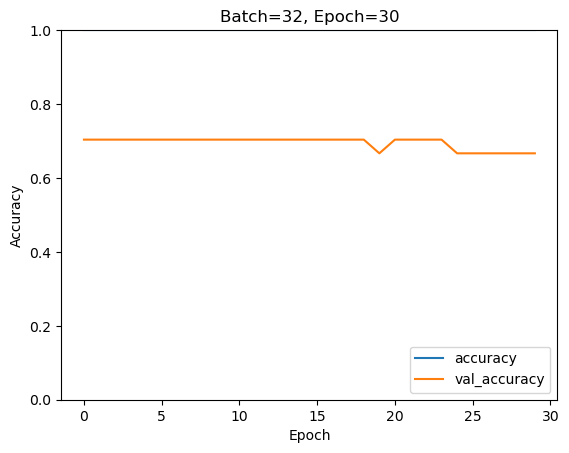

Epoch 1/30
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - accuracy: 1.0000 - loss: 2.5252e-05 - val_accuracy: 0.6667 - val_loss: 3.5196
Epoch 2/30
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 1.0000 - loss: 0.0013 - val_accuracy: 0.6667 - val_loss: 3.5208
Epoch 3/30
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 1.0000 - loss: 6.9923e-04 - val_accuracy: 0.6667 - val_loss: 3.5177
Epoch 4/30
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 1.0000 - loss: 3.5629e-04 - val_accuracy: 0.6667 - val_loss: 3.5075
Epoch 5/30
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 1.0000 - loss: 3.9696e-04 - val_accuracy: 0.6667 - val_loss: 3.4956
Epoch 6/30
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 1.0000 - loss: 7.0294e-05 - val_accuracy: 0.6667 - val_loss: 3.4866
Epoch 7/30
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 1.0000 - loss: 1.2156e-04 - val_accuracy: 0.6667 - val_loss: 3.4801
Epoch 8/30
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 1.0000 - loss: 9.7855e-05 - val_accuracy

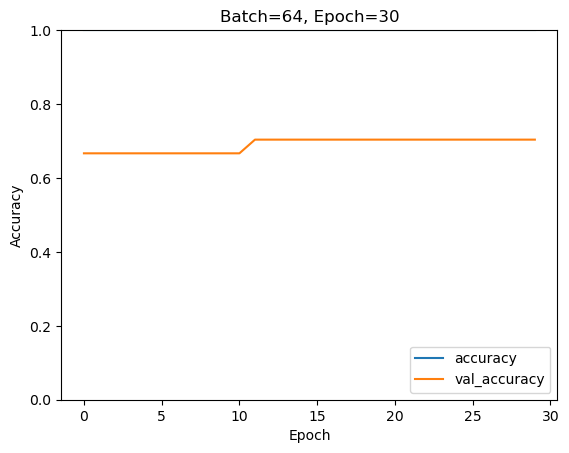

Epoch 1/40
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 1.0000 - loss: 0.0017 - val_accuracy: 0.7037 - val_loss: 3.5387
Epoch 2/40
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 1.0000 - loss: 5.5531e-05 - val_accuracy: 0.7037 - val_loss: 3.5475
Epoch 3/40
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 1.0000 - loss: 3.2770e-06 - val_accuracy: 0.7037 - val_loss: 3.5607
Epoch 4/40
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 1.0000 - loss: 1.9776e-05 - val_accuracy: 0.7037 - val_loss: 3.5613
Epoch 5/40
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 1.0000 - loss: 1.0568e-05 - val_accuracy: 0.7037 - val_loss: 3.5620
Epoch 6/40
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 1.0000 - loss: 4.6622e-05 - val_accuracy: 0.7037 - val_loss: 3.5639
Epoch 7/40
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 1.0000 - loss: 1.2103e-04 - val_accuracy: 0.7037 - val_loss: 3.5688
Epoch 8/40
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9938 - loss: 0.0161 - val_accu

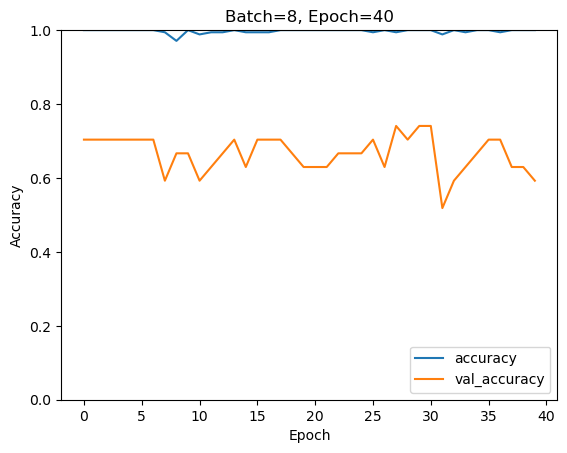

Epoch 1/40
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 1.0000 - loss: 0.0019 - val_accuracy: 0.6296 - val_loss: 3.4811
Epoch 2/40
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9973 - loss: 0.0113 - val_accuracy: 0.6667 - val_loss: 3.0708
Epoch 3/40
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 1.0000 - loss: 0.0043 - val_accuracy: 0.6667 - val_loss: 2.9165
Epoch 4/40
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 1.0000 - loss: 0.0021 - val_accuracy: 0.7037 - val_loss: 2.9590
Epoch 5/40
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9838 - loss: 0.0498 - val_accuracy: 0.7037 - val_loss: 2.8419
Epoch 6/40
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 1.0000 - loss: 4.8456e-04 - val_accuracy: 0.6667 - val_loss: 2.8575
Epoch 7/40
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 1.0000 - loss: 2.4216e-04 - val_accuracy: 0.6667 - val_loss: 2.8806
Epoch 8/40
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9965 - loss: 0.0031 - val_accuracy: 0.7037 - v

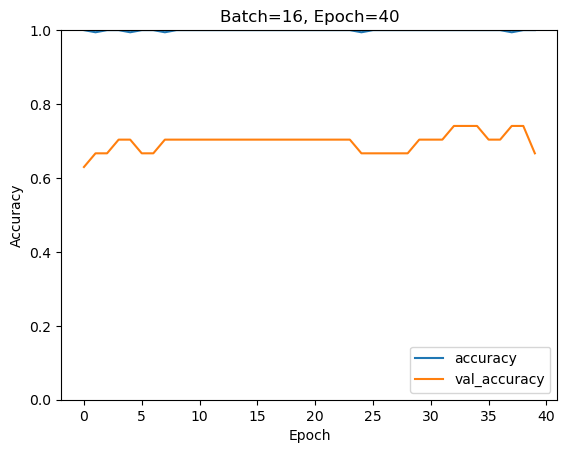

Epoch 1/40
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 1.0000 - loss: 1.8051e-04 - val_accuracy: 0.6667 - val_loss: 3.2616
Epoch 2/40
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 3.0356e-05 - val_accuracy: 0.6667 - val_loss: 3.3109
Epoch 3/40
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 1.2932e-04 - val_accuracy: 0.6667 - val_loss: 3.3381
Epoch 4/40
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 9.1987e-04 - val_accuracy: 0.6667 - val_loss: 3.3601
Epoch 5/40
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 3.2397e-04 - val_accuracy: 0.6667 - val_loss: 3.3731
Epoch 6/40
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 1.6539e-05 - val_accuracy: 0.6667 - val_loss: 3.3787
Epoch 7/40
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 3.4117e-04 - val_accuracy: 0.6667 - val_loss: 3.3841
Epoch 8/40
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 8.5241e-05 - val_accuracy: 0

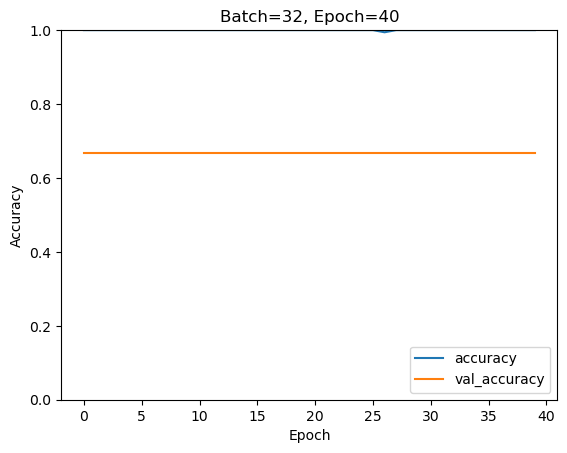

Epoch 1/40
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - accuracy: 1.0000 - loss: 1.7140e-04 - val_accuracy: 0.6667 - val_loss: 3.5347
Epoch 2/40
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 1.0000 - loss: 6.6216e-05 - val_accuracy: 0.6667 - val_loss: 3.5364
Epoch 3/40
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 1.0000 - loss: 6.4064e-05 - val_accuracy: 0.6667 - val_loss: 3.5377
Epoch 4/40
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 1.0000 - loss: 2.8507e-05 - val_accuracy: 0.6667 - val_loss: 3.5385
Epoch 5/40
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 1.0000 - loss: 8.2324e-05 - val_accuracy: 0.6667 - val_loss: 3.5397
Epoch 6/40
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 1.0000 - loss: 5.8429e-05 - val_accuracy: 0.6667 - val_loss: 3.5412
Epoch 7/40
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 1.0000 - loss: 4.0813e-05 - val_accuracy: 0.6667 - val_loss: 3.5426
Epoch 8/40
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 1.0000 - loss: 1.2705e-04 - val_accu

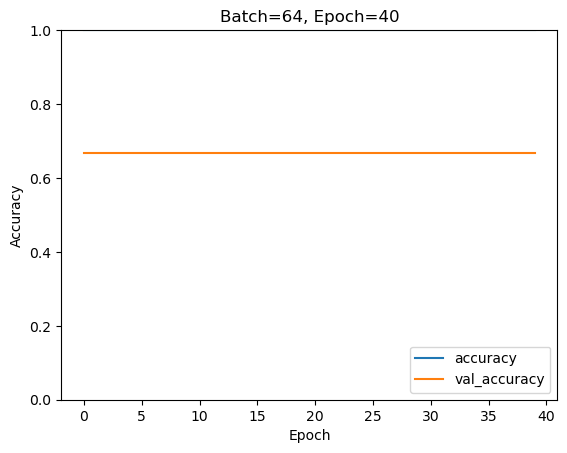

In [48]:
# Compile the model
model.compile(optimizer=Adam(learning_rate=0.001),
              loss='sparse_categorical_crossentropy',  # Use sparse categorical since labels are integers
              metrics=['accuracy'])

epoch_range = [10, 20, 30, 40]
batch_range = [8, 16, 32, 64]

for epoch in epoch_range:
    for batch in batch_range:
        # Train the model
        history = model.fit(
            train_images, train_labels,
            epochs=epoch,
            batch_size=batch,
            validation_data=(test_images, test_labels)
        )

        test_loss, test_acc = model.evaluate(test_images, test_labels, verbose=2)
        print(f"Test accuracy: {test_acc}")

        plt.plot(history.history['accuracy'], label='accuracy')
        plt.plot(history.history['val_accuracy'], label='val_accuracy')
        plt.xlabel('Epoch')
        plt.ylabel('Accuracy')
        plt.legend(loc='lower right')
        plt.title(f"Batch={batch}, Epoch={epoch}")
        plt.ylim(0,1)
        plt.show()